In [1]:
# from ipynb.fs.full.CMC_Webscraping_Final import *

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [22]:
df = pd.read_csv("../ETH-USD.csv")

In [23]:
df = df.set_index('Date')

In [24]:
def SMA(df):
    df['SMA_21days'] = df.iloc[:,4].rolling(window=21).mean()
    df['SMA_50days'] = df.iloc[:,4].rolling(window=50).mean()
    df['SMA_100days'] = df.iloc[:,4].rolling(window=100).mean()

In [25]:
def EMA(df):
    df['EMA_21days'] = df['Close'].ewm(span=21,adjust=False).mean()
    df['EMA_50days'] = df['Close'].ewm(span=50,adjust=False).mean()
    df['EMA_100days'] = df['Close'].ewm(span=100,adjust=False).mean()

In [26]:
def RSIs(df):
    df['diff'] = df.Close.diff()
    df['pos'] = df['diff'].clip(lower=0)
    df['neg'] = -1*df['diff'].clip(upper=0)
    ema_pos = df['pos'].ewm(com=13, adjust=False).mean()
    ema_neg = df['neg'].ewm(com=13, adjust=False).mean()
    relative_str = ema_pos / ema_neg
    df['RSI'] = 100-(100/(1+relative_str))
    df['Stochastic_RSI'] = (df['RSI']-df['RSI'].rolling(14).min())/(df['RSI'].rolling(14).max()-(df['RSI'].rolling(14).min()))

In [27]:
SMA(df)
EMA(df)
RSIs(df)

In [28]:
df=df.drop(['pos','neg','diff','Open','High','Low'], axis=1)
df=df.dropna(axis=0)

Machine Learning:

In [29]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
# from tensorflow.keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [30]:
df.corr()['Close'].sort_values(ascending=False)

Close             1.000000
Adj Close         1.000000
EMA_21days        0.983361
EMA_50days        0.958792
EMA_100days       0.918136
SMA_100days       0.439729
SMA_50days        0.337770
SMA_21days        0.318339
Volume            0.262265
Stochastic_RSI    0.021217
RSI              -0.073871
Name: Close, dtype: float64

In [ ]:
# df = df.loc['2021-02-01':]

In [ ]:
# len(df)

In [31]:
X = df.drop('Close',axis=1)
Y = df['Close'].copy()

<AxesSubplot:title={'center':'Correlation Matrix'}>

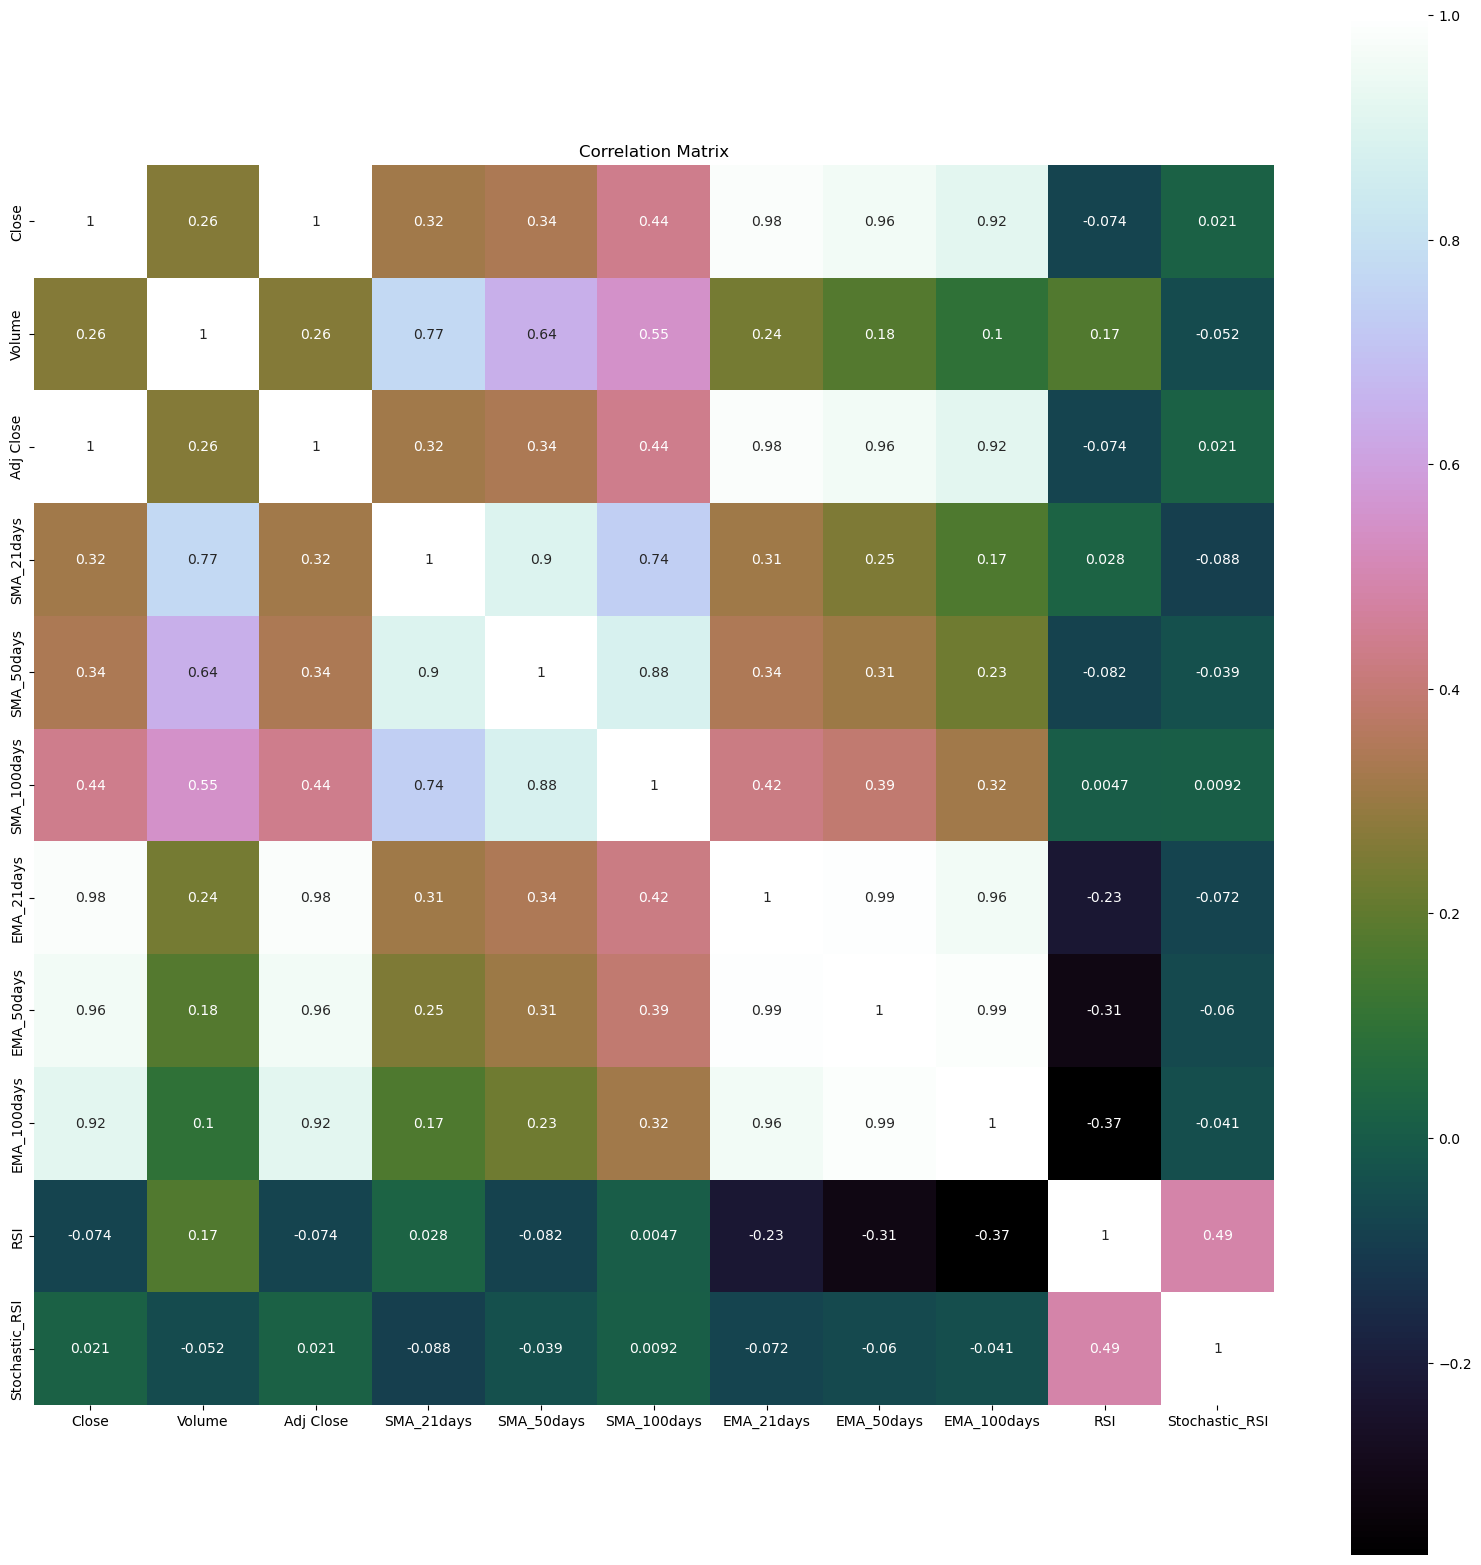

In [32]:
correlation = df.corr()
plt.figure(figsize=(20,20))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

<Figure size 2000x2000 with 0 Axes>

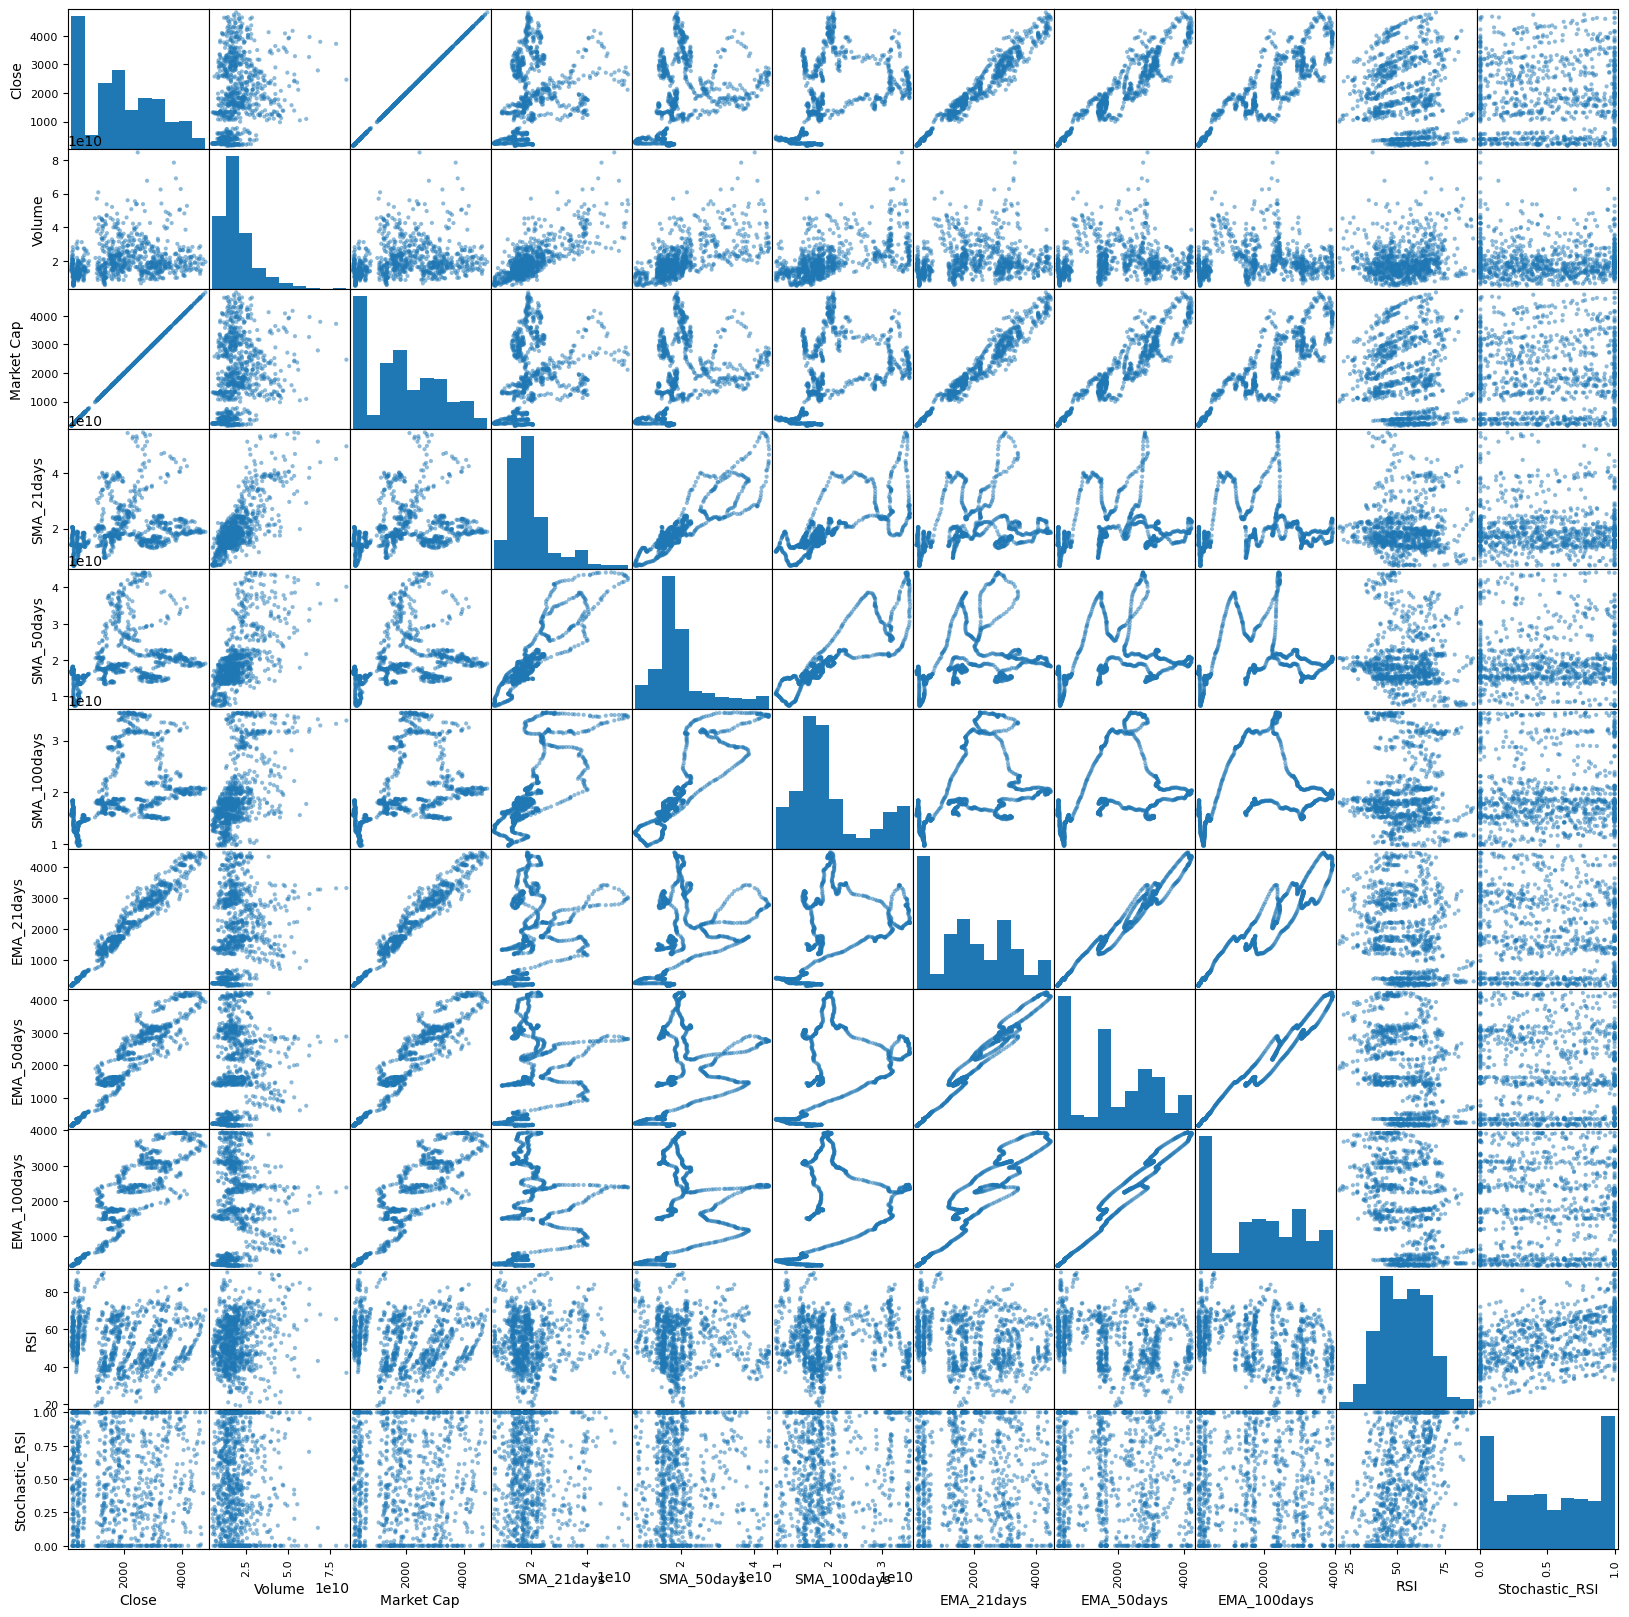

In [33]:
plt.figure(figsize=(20,20))
scatter_matrix(df, figsize=(20,20))
plt.show()

In [34]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(20,'Score').set_index('Specs')

,Score
Specs,
EMA_21days,2.777900e+04
EMA_50days,1.079652e+04
EMA_100days,5.089187e+03
SMA_100days,2.272481e+02
SMA_50days,1.220842e+02
SMA_21days,1.069035e+02
Volume,7.002281e+01
RSI,5.201508e+00
Stochastic_RSI,4.269537e-01


In [35]:
validation_size = 0.3
train_size = int(len(X) * (1-validation_size))
X_train, X_validation = X[0:train_size], X[train_size:len(X)]
Y_train, Y_validation = Y[0:train_size], Y[train_size:len(X)]

In [36]:
num_folds = 10
seed = 7
scoring='neg_mean_squared_error'

In [40]:
models = []
# models.append(('LR', LinearRegression()))
# models.append(('LASSO', Lasso()))
# models.append(('EN', ElasticNet()))
# models.append(('KNN', KNeighborsRegressor()))
# models.append(('CART', DecisionTreeRegressor()))
# models.append(('SVR', SVR()))

# models.append(('MLP', MLPRegressor())) #Don't do this lmao, significant error

# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
# models.append(('ETR', ExtraTreesRegressor()))

In [41]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    ## K Fold analysis:
    kfold = KFold(n_splits=num_folds, random_state=None)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    
    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    # Test results
    test_result = mean_squared_error(res.predict(X_validation), Y_validation)
    test_results.append(test_result)
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

ABR: 22958.357609 (36841.972917) 3946.756005 3295.393263
GBR: 8776.444710 (15298.985013) 33.118512 231.047104
RFR: 5720.308363 (7790.412825) 16.087456 565.248650


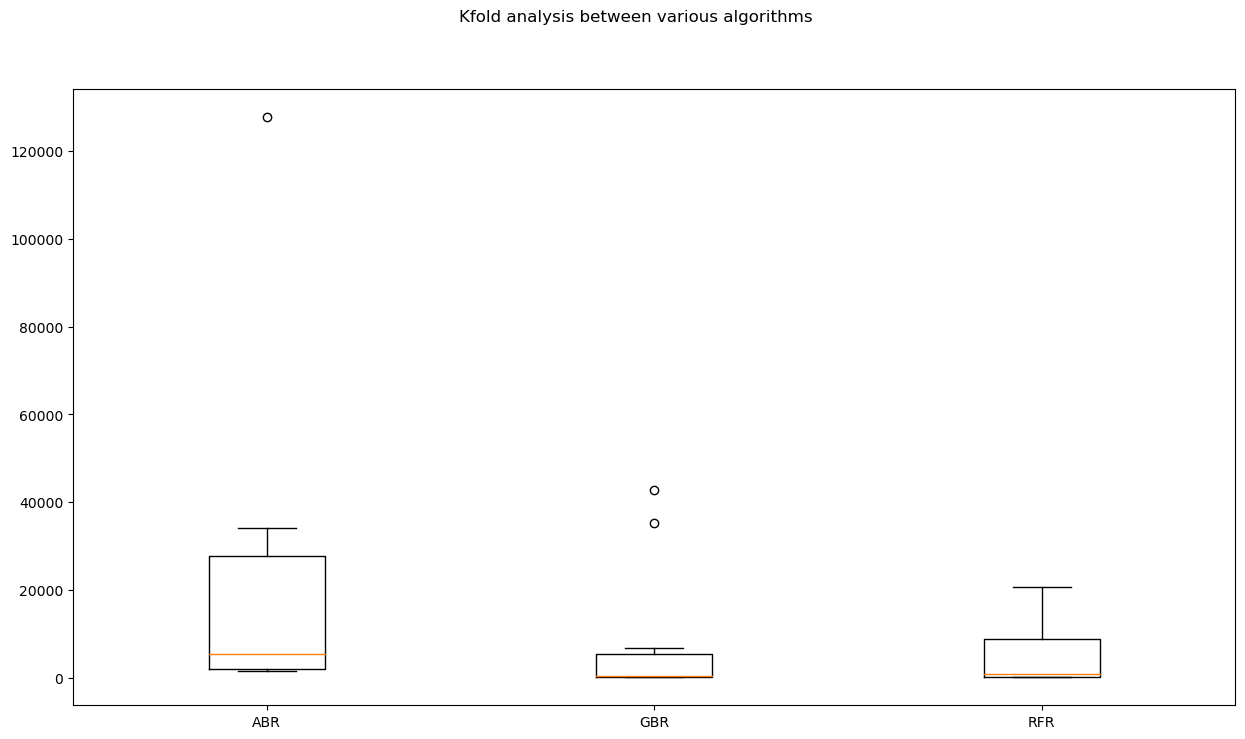

In [42]:
fig = plt.figure()
fig.suptitle('Kfold analysis between various algorithms')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

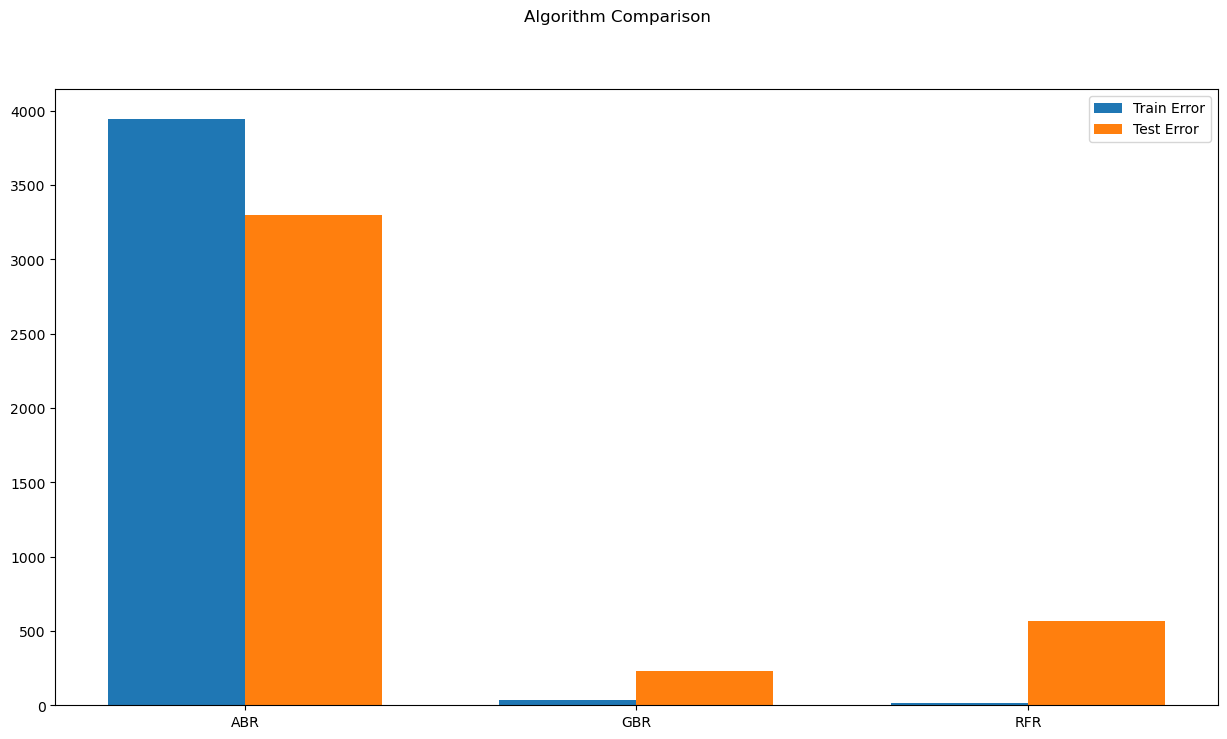

In [43]:
# compare algorithms
fig = plt.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()

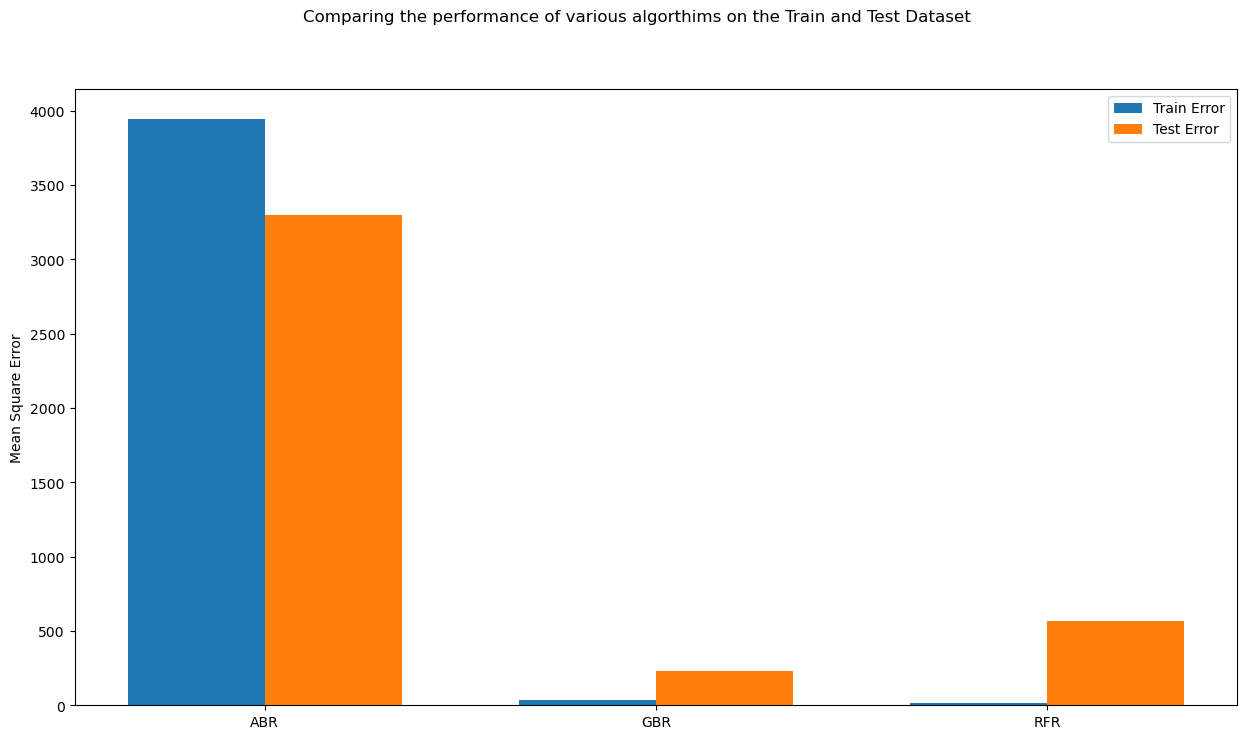

In [44]:
# compare algorithms
fig = plt.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.ylabel('Mean Square Error')
plt.show()

In [48]:
model = RandomForestRegressor()
model.fit(X_train, Y_train)

RandomForestRegressor()

In [49]:
predictions = model.predict(X_validation)
print(mean_squared_error(Y_validation, predictions))
print(r2_score(Y_validation, predictions))

1243.764596195647
0.9976148560549954


In [54]:
df2 = pd.DataFrame(predictions)

In [55]:
# df2.columns = ['Prediction']
y_val = []
for i in Y_validation:
    y_val.append(i)
df2['Y_validation'] = y_val

In [61]:
df2

,0,Y_validation
0,2689.802793,2679.162598
1,3003.872019,2983.586914
2,3014.045161,3014.648193
3,3067.302349,3057.476074
4,3154.575012,3142.470703
...,...,...
280,1306.700754,1299.464600
281,1259.591549,1287.221069
282,1233.961665,1255.268311
283,1203.881118,1221.819214


In [66]:
df2.columns = [['Prediction','Y_validation']]

In [67]:
df2

,Prediction,Y_validation
0,2689.802793,2679.162598
1,3003.872019,2983.586914
2,3014.045161,3014.648193
3,3067.302349,3057.476074
4,3154.575012,3142.470703
...,...,...
280,1306.700754,1299.464600
281,1259.591549,1287.221069
282,1233.961665,1255.268311
283,1203.881118,1221.819214


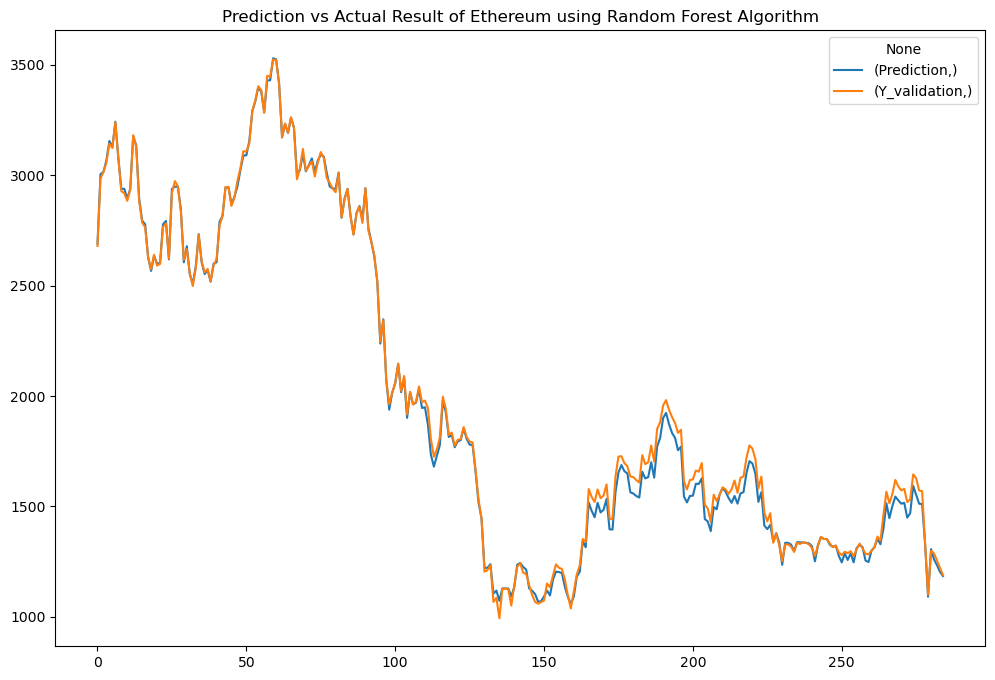

In [72]:
fig, ax = plt.subplots(figsize=(12,8))
df2[['Prediction','Y_validation']].plot(ax=ax)
plt.title('Prediction vs Actual Result of Ethereum using Random Forest Algorithm')
plt.show()

In [69]:
test_prediction = pd.Series(predictions.reshape(len(predictions),))

In [70]:
result = mean_squared_error(Y_validation, predictions)

In [71]:
result

1243.764596195647